<a href="https://colab.research.google.com/github/pmnerfed/capstone_option_trading/blob/main/Review/Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long/Short Term Trading Strategies

In [65]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")



In [66]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [70]:
try:
    from get_all_tickers import get_tickers as gt
except ModuleNotFoundError:
    !pip install get-all-tickers
    from get_all_tickers import get_tickers as gt

from get_all_tickers.get_tickers import SectorConstants

## Gathering the data

For our analysis we are using 10 technology companies.

| Ticker | Company Name                             |
|--------|------------------------------------------|
| AAPL   | Apple Inc.                                |
| ADBE   | Adobe Inc.                                |
| ORCL   | Oracle Corporation                        |
| EBAY   | eBay Inc.                                 |
| MSFT   | Microsoft Corporation                     |
| QCOM   | Qualcomm Incorporated                    |
| HPQ    | HP Inc.                                   |
| JNPR   | Juniper Networks, Inc.                    |
| AMD    | Advanced Micro Devices, Inc.              |
| IBM    | International Business Machines Corporation|
| SPY    | SPDR S&P 500 ETF Trust                    |

In [67]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%%**********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2020-12-24,131.970001,499.859985,91.809998,50.119999,24.260000,119.206497,22.400000,222.750000,64.959999,148.789993,369.000000
2020-12-28,136.690002,498.950012,91.599998,50.240002,24.270000,119.330788,22.559999,224.960007,64.870003,147.740005,372.170013
2020-12-29,134.869995,502.109985,90.620003,50.860001,24.049999,118.355644,22.190001,224.149994,64.459999,148.490005,371.459991
2020-12-30,133.720001,497.450012,92.290001,50.549999,24.320000,118.871895,22.200001,221.679993,64.400002,149.949997,371.989990
2020-12-31,132.690002,500.119995,91.709999,50.250000,24.590000,120.344170,22.510000,222.419998,64.690002,152.339996,373.880005


## Traditional Model

### Finding cointegrated Pairs

In [20]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return score_matrix, pvalue_matrix, pairs

[('ADBE', 'MSFT', 0.02081478537252975), ('EBAY', 'IBM', 0.02253077551368095), ('EBAY', 'ORCL', 0.032897950499253995), ('IBM', 'ORCL', 0.0019626127372477952), ('IBM', 'SPY', 0.0009854049357312063), ('ORCL', 'SPY', 0.00011442648552332336)]


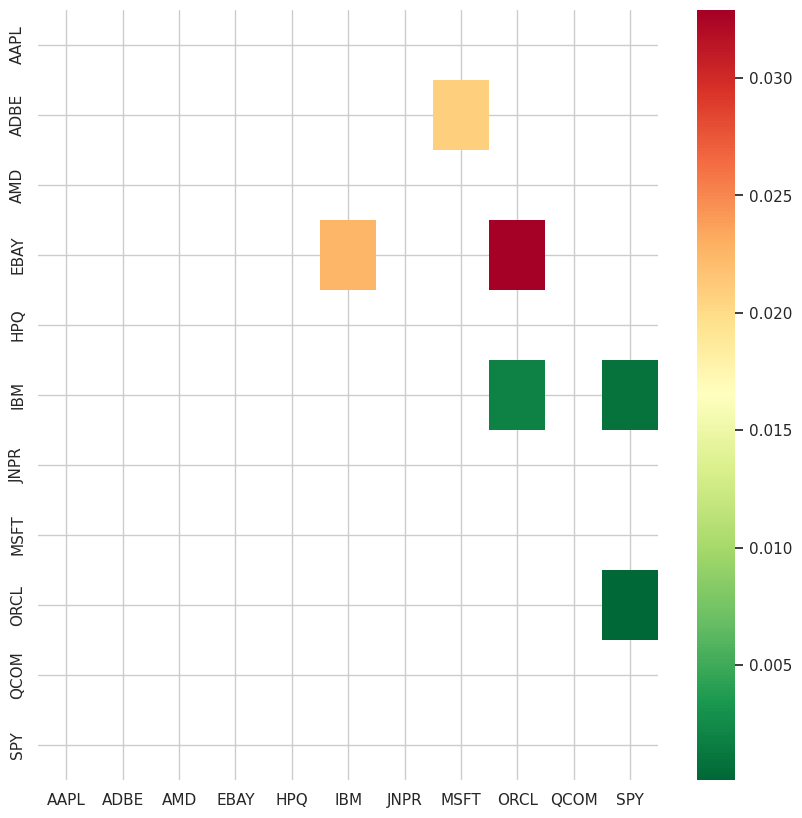

In [25]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

Lets look at pair trading for of the pairs (IBM, ORCL).

In [27]:
S1 = df['IBM']
S2 = df['ORCL']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0019626127372477952

### Calculating the spread across the first pair

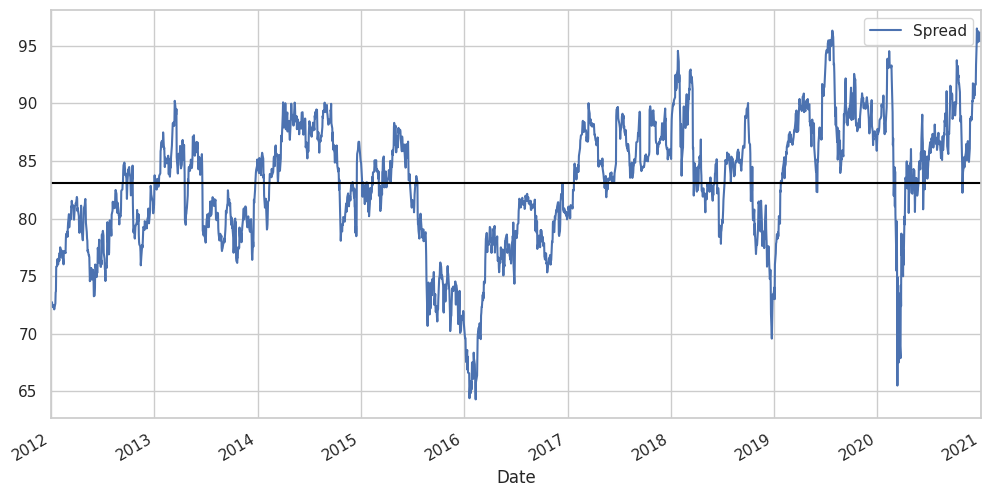

In [31]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['IBM']
b = results.params['IBM']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2012-01-01', '2021-01-01')
plt.legend(['Spread']);

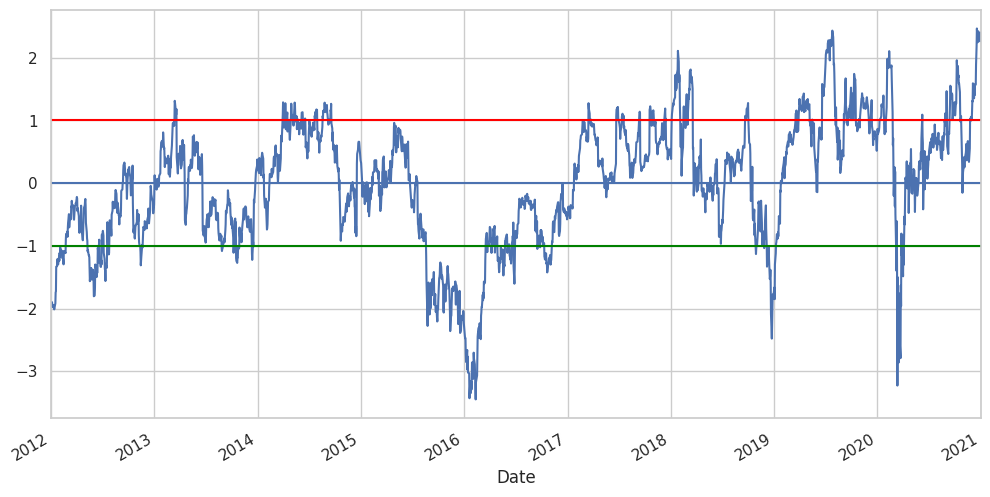

In [37]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(spread).plot(figsize=(12,6))
plt.axhline(zscore(spread).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2012-01-01', '2021-01-01')
plt.show()

### Trading Signals

In [38]:
ratios = df['IBM'] / df['ORCL']
print(len(ratios) * .70 )

1585.5


In [48]:
train = ratios[:1585]
test = ratios[1585:]

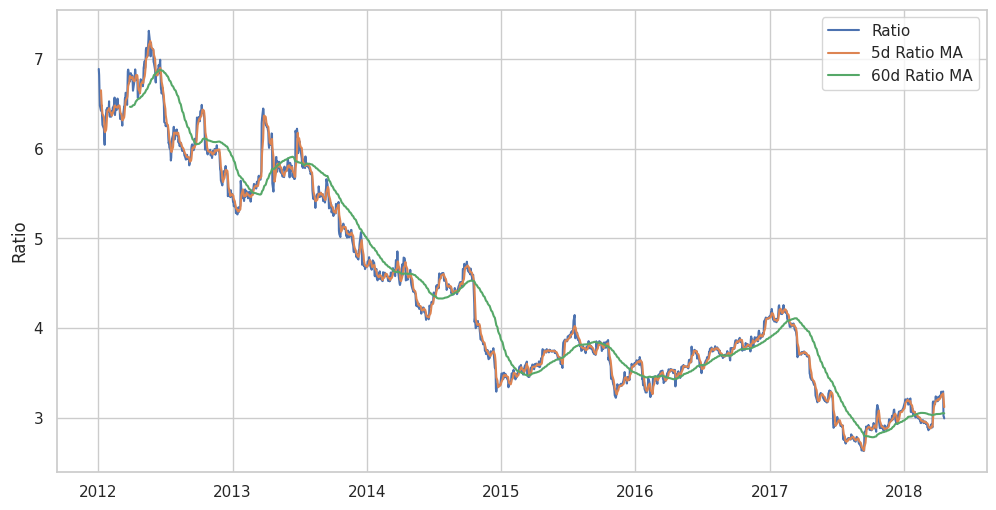

In [49]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

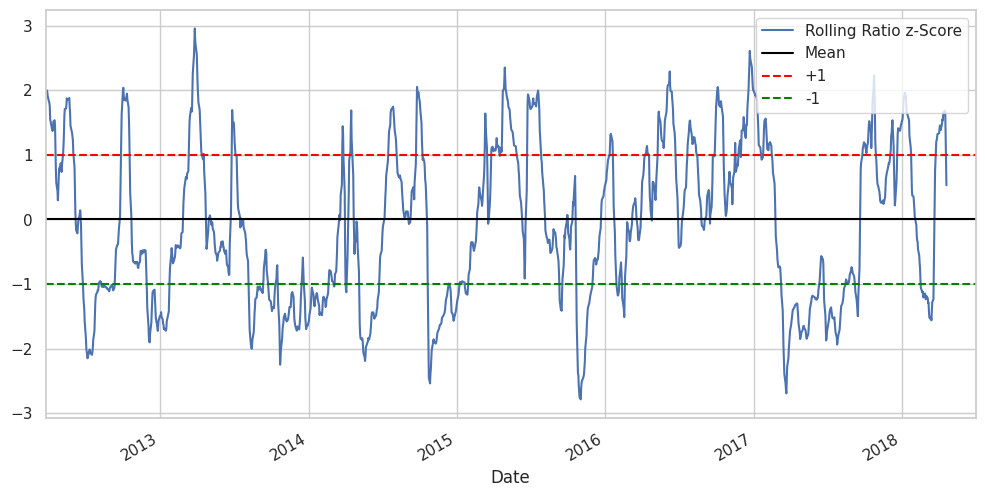

In [51]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2012-03-25', '2018-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

As we know the process tobe mean reverting i.e. if it goes beyond 1 standard deviation it will tend toward the mean. Using this information we can create following trading signals:
- Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
- Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

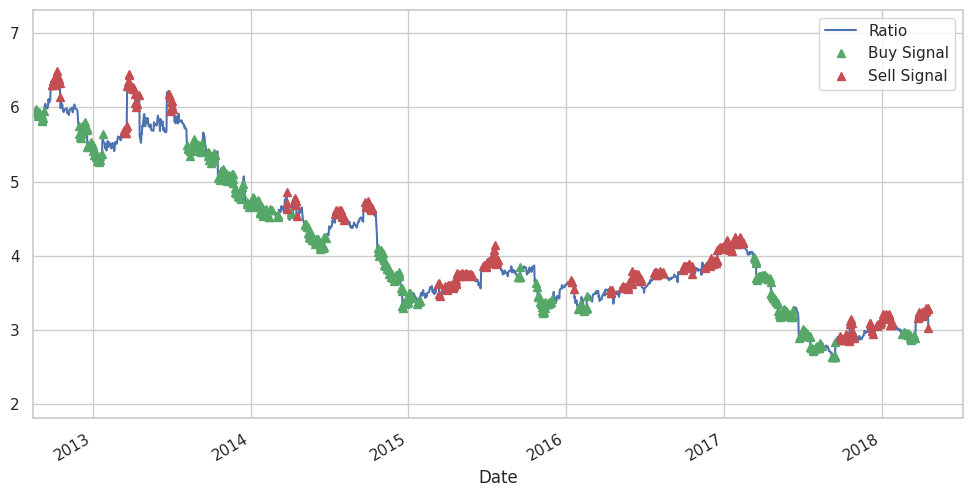

In [55]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2012-08-15','2018-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

<Axes: xlabel='Date'>

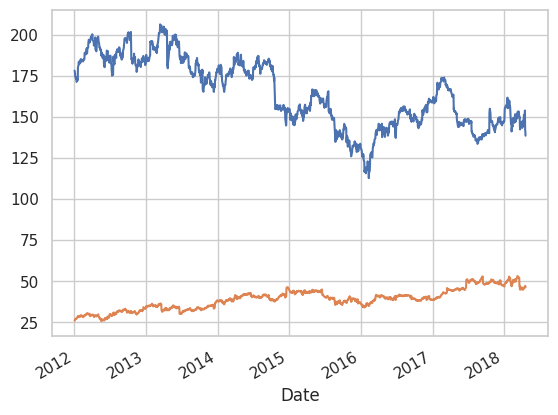

In [61]:
S1.plot()
S2.plot()

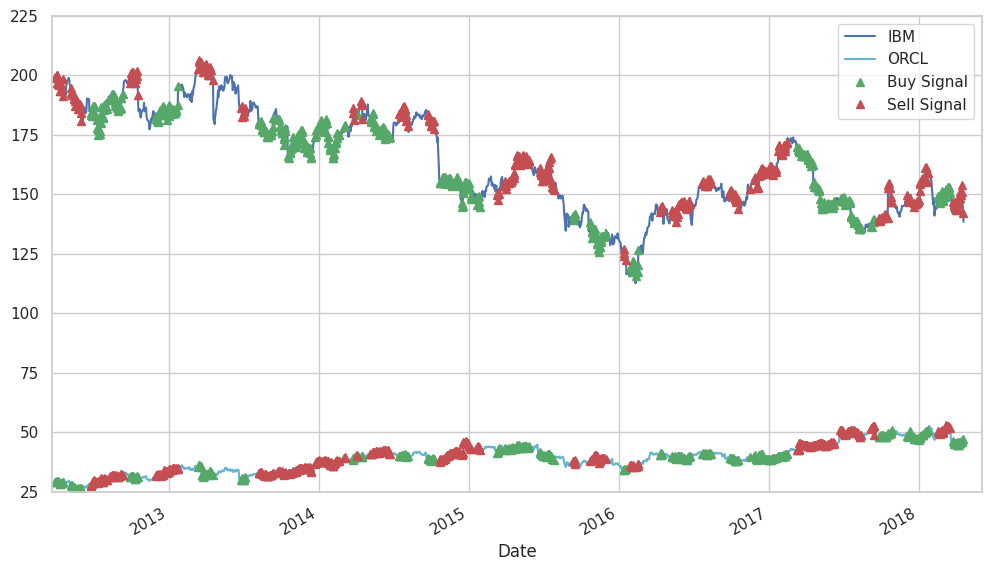

In [62]:
plt.figure(figsize=(12,7))
S1 = df['IBM'].iloc[:1585]
S2 = df['ORCL'].iloc[:1585]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 225)
plt.xlim('2012-03-22', '2018-06-04')

plt.legend(['IBM', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()

In [63]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
         elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [64]:
trade(df['IBM'].iloc[1585:], df['ORCL'].iloc[1585:], 60, 5)


1582.332371853834

## Improving Pair selection

We will try using SVM and Random forest methods to find contegrated pairs.

We will look at a lot more stock tickers to test the effectiveness of the pair selection algorithm.

The final check would be that the process should be stationary.

#### Getting data

In [113]:
import requests
import pandas as pd

def get_top_n_tickers(n):
    headers = {
        'authority': 'api.nasdaq.com',
        'accept': 'application/json, text/plain, */*',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
        'origin': 'https://www.nasdaq.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://www.nasdaq.com/',
        'accept-language': 'en-US,en;q=0.9',
    }

    params = (
        ('tableonly', 'true'),
        ('limit', '25'),
        ('offset', '0'),
        ('download', 'true'),
        ('exchange', 'nasdaq')
    )

    r = requests.get('https://api.nasdaq.com/api/screener/stocks', headers=headers, params=params)
    data = r.json()['data']
    df = pd.DataFrame(data['rows'], columns=data['headers'])
    df = df.dropna(subset={'marketCap'})
    df = df[df.sector == "Technology"]

    def cust_filter(mkt_cap):
            if 'M' in mkt_cap:
                return float(mkt_cap[1:-1])
            elif 'B' in mkt_cap:
                return float(mkt_cap[1:-1]) * 1000
            elif mkt_cap == '':
                return 0
            else:
                return float(mkt_cap[1:]) / 1e6

    df['marketCap'] = df['marketCap'].apply(cust_filter)

    df = df.sort_values('marketCap', ascending=False)[:n].reset_index()
    display(df[["symbol", 'name']])
    return df.symbol.to_list()

In [114]:
tickers_tech = get_top_n_tickers(40)

,symbol,name
0,MSFT,Microsoft Corporation Common Stock
1,GOOG,Alphabet Inc. Class C Capital Stock
2,GOOGL,Alphabet Inc. Class A Common Stock
3,NVDA,NVIDIA Corporation Common Stock
4,META,Meta Platforms Inc. Class A Common Stock
5,INTU,Intuit Inc. Common Stock
6,ADBE,Adobe Inc. Common Stock
7,AMD,Advanced Micro Devices Inc. Common Stock
8,AVGO,Broadcom Inc. Common Stock
9,QCOM,QUALCOMM Incorporated Common Stock


In [119]:
tech_data = pdr.get_data_yahoo(tickers_tech, start, end)['Close']

[*********************100%%**********************]  40 of 40 completed


In [120]:
tech_data.head()

,AAPL,ADBE,ADI,ADP,AMAT,AMD,ANSS,AVGO,CHKP,CTSH,...,QCOM,SPLK,SSNC,STX,SWKS,TTWO,TXN,WDAY,WDC,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,28.570000,36.029999,47.813873,10.70,5.48,57.389999,28.950001,52.970001,32.860001,...,55.270000,NaN,9.050,16.430000,16.820000,14.00,29.760000,NaN,30.980000,NaN
2012-01-04,14.765714,28.280001,35.980000,47.761192,10.76,5.46,56.400002,28.450001,51.730000,32.980000,...,55.830002,NaN,8.950,16.820000,16.780001,14.00,29.570000,NaN,31.299999,NaN
2012-01-05,14.929643,28.480000,36.139999,48.112377,10.83,5.46,57.299999,28.490000,52.270000,33.645000,...,56.060001,NaN,9.005,17.900000,17.280001,14.66,29.780001,NaN,32.759998,NaN
2012-01-06,15.085714,28.719999,35.900002,48.182617,11.01,5.43,56.939999,28.309999,51.360001,33.205002,...,56.160000,NaN,9.000,18.299999,17.150000,14.76,29.780001,NaN,33.490002,NaN
2012-01-09,15.061786,28.530001,36.599998,47.998245,11.34,5.59,56.680000,30.219999,51.330002,33.320000,...,55.910000,NaN,9.005,18.190001,17.809999,14.91,30.160000,NaN,33.750000,NaN


Now we have the closing prices for top 40 tech stocks and we can use these for our analysis.

#### Random Forest

we will try to use the eandom forest to detect similar pairs of stocks and test cointegration between each pair.

This would improve efficiency in detecting suitable pairs from a large number of stocks improving upon the brute force method of the traditional method.

In [ ]:
## Random forest

#### Discuss the findings and pros and cons

### LSTM

- We will select a pair from above
- generate features like moving average and volume data
- create a LSTM model
- train the LSTM model


### Testing the strategy

### Comparing strategies with traditional method

## Conclusion